In [10]:
import sys
import numpy as np
from scipy.stats import multivariate_normal
import signal
import torch
import re
from torch.distributions.multivariate_normal import MultivariateNormal
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '../SOGAtorch/src')
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *

torch.set_default_dtype(torch.float64)

In [11]:
def preprocess_program(program):
    p = convert_and_normalize_gm_structure(program)
    p = convert_uniform_structure(p)
    return p


def convert_and_normalize_gm_structure(text):
    # Regular expression to find gm structure
    pattern = r'gm\(\s*(\[[^\]]+\](?:,\s*\[[^\]]+\])*)\s*\)'
    
    # Match all occurrences of the structure
    matches = re.findall(pattern, text)
    
    # Process each match
    converted_text = text
    for match in matches:
        # Find all sets of [pi, mu, s] inside the matched string
        elements = re.findall(r'\[\s*([0-9.-]+)\s*,\s*([0-9.-]+)\s*,\s*([0-9.-]+)\s*\]', match)
        
        # Separate pi, mu, and s into their own lists
        pi_list = [float(e[0]) for e in elements]
        mu_list = [e[1] for e in elements]
        s_list = [e[2] for e in elements]
        
        # Normalize pi_list
        pi_sum = sum(pi_list)
        normalized_pi_list = [pi / pi_sum for pi in pi_list] if pi_sum != 0 else pi_list
        
        # Format the new gm structure with normalized pi_list
        new_gm = f'gm([{", ".join(f"{pi:.6f}" for pi in normalized_pi_list)}], [{", ".join(mu_list)}], [{", ".join(s_list)}])'
        
        # Replace the old structure with the new one in the text
        converted_text = converted_text.replace(f'gm({match})', new_gm)
    
    return converted_text

def convert_uniform_structure(text):
    # Regular expression to find the structure uniform([a, b], c)
    pattern = r'uniform\(\s*\[\s*([0-9.-]+)\s*,\s*([0-9.-]+)\s*\]\s*,\s*([0-9.-]+)\s*\)'
    
    # Find all matches of uniform([a, b], c)
    matches = re.findall(pattern, text)
    
    # Process each match
    converted_text = text
    for match in matches:
        a = float(match[0])  # Extract 'a'
        b = float(match[1])  # Extract 'b'
        c = match[2]         # Extract 'c'
        
        # New value for 'a + b'
        new_b = a + b
        
        # Format the new uniform structure
        new_uniform = f'uniform([{a:.6f}, {new_b:.6f}], {c})'
        
        # Replace the old structure with the new one in the text
        old_uniform = f'uniform([{match[0]}, {match[1]}], {match[2]})'
        converted_text = converted_text.replace(old_uniform, new_uniform)
    
    return converted_text

In [12]:
def smooth_program(program_text):
    """
    Finds and modifies assignment lines where the variable is a letter or alphanumeric
    and the right-hand side does not contain 'gm' or 'uniform'.
    
    Args:
        program_text (str): The text of the program to analyze and modify.
    
    Returns:
        str: The modified program text.
    """
    # Define the regex pattern to identify assignments
    pattern = r'^(\s*([a-zA-Z]\w*)\s*=\s*([^;]*))(;?)'
    
    # Split the program into lines
    lines = program_text.splitlines()
    modified_lines = []
    
    for line in lines:
        match = re.match(pattern, line)
        if match:
            full_assignment, var, expression, semicolon = match.groups()
            # Check if 'gm' or 'uniform' is in the expression
            if 'gm' not in expression and 'uniform' not in expression:
                # Modify the assignment
                modified_assignment = f"{full_assignment} + gauss(0., 0.05){semicolon}"
                modified_lines.append(modified_assignment)
            else:
                # Keep the original line
                modified_lines.append(line)
        else:
            # Keep non-matching lines unchanged
            modified_lines.append(line)
    
    # Join the lines back into a single text
    return '\n'.join(modified_lines)   

In [13]:
data_var_list = ['a', 'b']
#data = np.random.uniform(0, 1, 100)
#EXPERIMENT 1
data = [[np.random.normal(1, 2), np.random.normal(8, 2)] for _ in range(10000)]
#EXPERIMENT 2
'''
data = []
for _ in range(5000):
    a = np.random.normal(1, 2)
    if a < 0:
        b = a * 3
    else: 
        b = np.random.normal(8, 1)
    data.append([a, b])
'''

'\ndata = []\nfor _ in range(5000):\n    a = np.random.normal(1, 2)\n    if a < 0:\n        b = a * 3\n    else: \n        b = np.random.normal(8, 1)\n    data.append([a, b])\n'

In [ ]:
#EXPERIMENT 1
text_baseline = 'a = gm([1, 1, 2]);\nb = gm([1, 8, 2]);'
#text= 'a = uniform([-3, 3], 1);b = uniform([7, 2], 1);'
#text = 'a = gm([1, 1, 2]);b = gm([1, 8, 2]);'
#text = 'a = 8 * uniform([7.000000, 8.800000], 1);\nb = gm([0.264706, 0.735294, 1], [5, 1, 1.4], [1, 8.0, 9.0]) * uniform([2.000000, 9.200000], 6);'
#text = 'b = 6  * e + uniform([3, 7], 1);\nc = 4 * 7;\nc = 5 * gm([0, 6.0, 6], [4, 5, 0]);\nd = 3 - 9;\na = gm([5.7, 0, 0.5]) * gm([8.4, 1.1, 4]);'
#text = 'b = gm([1, 9, 2], [0, 6, 4.5])  - c;\na = gm([6, 1, 2.0]);'

#EXPERIMENT 1 GECCO
text = 'b = 6 * c;\na = uniform([0, 5], 4) * gm([6, 2, 2]);\nb = uniform([4, 6.1], 1);'
text = 'b = a + gm([8, 1.2, 6]);\na = uniform([3, 5], 2) * gm([7, 0.4, 6.9]);'
text = 'a = 4  * gm([6, 0, 1], [5.8, 3.5, 5.1]) + e;\nb = 1  * uniform([5, 6.1], 2)  - 0;'
text= 'a = 1 * uniform([1, 7], 1);\nb = gm([1.4, 6.2, 8], [1, 4.4, 5.9]);'
text = 'b = 4  * uniform([0, 4.2], 2)  - 1  * e;\na = uniform([5, 6], 3)  - uniform([3, 8], 1);'
text = ' a = gm([5, 2, 5.2]) + 5  * gm([2, 0, 0]);\nb = 2 * uniform([2, 4], 4);'
text = 'b = 2 * uniform([0, 9.6], 1);\na = gm([1, 2.6, 4], [7.1, 0, 4.2]) + 0  * gm([9.4, 3.2, 2], [3, 1.0, 5.4]);'
text = 'a = uniform([0, 3.8], 1);\nb = 2 * uniform([1, 6.2], 1);'

#EXPERIMENT 2
#text = ' a = uniform([5, 7], 1)  - 7;\nb = 1 * gm([9, 8.4, 2], [7, 0, 6]);'
#text = 'a = 9  * a + uniform([0, 7], 1);\nb = gm([8.4, 4.3, 8], [8.1, 9.9, 7])  - 1;'
#text = 'b = e + gm([0.4, 8.8, 1.4], [6, 6.6, 6.4]);\na = gm([1.0, 0.3, 8.0], [3, 5, 1.5]) * uniform([0, 1], 4);'
#text = 'a = uniform([0, 5.1], 1); \nb = 1 * gm([2, 0, 6.3], [2.8, 8, 0.9]);'

#EXPERIMENT 2 HOLES
#text= 'a = gm([4.0, 1.5, 2.3]) ; \nb = gm([2.5, 0, 9], [5.2, 7.1, 2]);\nif a < 0 {\n    b = uniform([0, 1], 3)  - gm([9.8, 5, 6], [4, 4, 1.0]); \n} else { \n   e = gm([0.9, 5, 6], [3.4, 5, 5], [4.7, 2, 1.6]) * uniform([5, 9.4], 1); \n} end if;'
#text = 'a = gm([6.1, 1, 2]) ; \nb = gm([6.8, 8.1, 1.0]); \nif a < 0 { \n   b = 3 * a; \n} else { \n   c =2* b; \n} end if;'
#text = 'a = gm([2, 0.8, 2]) ; \nb = gm([8, 8, 1]); '# \nif a < 0 { \n  b = 5  - gm([2, 9.5, 5], [5, 8, 2.0]); \n} else { \n    d = gm([6.1, 5, 9.6], [2.4, 4.8, 3.2]) * gm([2.1, 5, 4]); \n} end if;'
#text_baseline = 'a = gm([1, 1, 2]);\nif a < 0 {\n  b = 3*a;\n} else{ \n  b = gm([1, 8, 1]);\n} end if;'
text_baseline = preprocess_program(text_baseline)
text = preprocess_program(text)

#text = smooth_program(text)
#text_baseline = smooth_program(text_baseline)

print(text_baseline)
print(text)
compiledText=compile2SOGA_text(text)
compiledText_baseline=compile2SOGA_text(text_baseline)

cfg = produce_cfg_text(compiledText)
cfg_baseline = produce_cfg_text(compiledText_baseline)


output_dist = start_SOGA(cfg)
output_dist_baseline = start_SOGA(cfg_baseline)

a = gm([1.000000], [1], [2]);
b = gm([1.000000], [8], [2]);
b = 2 * uniform([0.000000, 9.600000], 1);
a = gm([0.123457, 0.876543], [2.6, 0], [4, 4.2]) + 0  * gm([0.758065, 0.241935], [3.2, 1.0], [2, 5.4]);


In [29]:
# Define a custom exception for timeouts
class TimeoutException(Exception):
    pass

# Define a handler function for the timeout
def handler(signum, frame):
    raise TimeoutException("Code execution exceeded time limit")


def compute_likelihood2(output_dist):
    likelihood = np.zeros(len(data))
    indexes = {element: [index for index, value in enumerate(output_dist.var_list) if value == element] for element in data_var_list}
    marginal_means_components = []
    marginal_covariance_matrices_components = []
    for i in range(output_dist.gm.n_comp()):
        marginal_means = []
        covariance_index = []
        marginal_covariance_matrix = []
        for element, index_list in indexes.items():
            marginal_means.append(output_dist.gm.mu[i][index_list][0])
            covariance_index.append(index_list[0])

        marginal_covariance_matrix.append(output_dist.gm.sigma[i][np.ix_(covariance_index,covariance_index)])
        marginal_means_components.append(marginal_means)
        marginal_covariance_matrices_components.append(marginal_covariance_matrix)

    for j in range(len(data)):
        for i in range(output_dist.gm.n_comp()):
            likelihood[j] = likelihood[j] + output_dist.gm.pi[i] * multivariate_normal.pdf(data[j], mean = marginal_means_components[i], cov = marginal_covariance_matrices_components[i][0], allow_singular=True)

        likelihood[j] = np.log(likelihood[j])
        #log_total_likelihood = log_total_likelihood + np.log(likelihood[j])
    sum_likelihood = np.sum(likelihood)
    #fitness = log_total_likelihood
    fitness = sum_likelihood/len(data)
    return fitness, likelihood

# Main code
try:
    # Set the timeout handler to raise TimeoutException after 5 seconds
    #signal.signal(signal.SIGALRM, handler)
    #signal.alarm(5)  # Set the timeout to 5 seconds
    fitness,l1 = compute_likelihood2(output_dist)
    fitness_baseline, l1 = compute_likelihood2(output_dist_baseline)

    # Cancel the alarm if the code completes within the time limit
    #signal.alarm(0)

except TimeoutException as e:
    print("Caught TimeoutException:", e)

print(fitness)
print(fitness_baseline)

-5.228588558527704
-4.23108256635992


In [ ]:

def compute_likelihood_torch(output_dist):
    likelihood = torch.zeros(len(data))
    indexes = {element: [index for index, value in enumerate(output_dist.var_list) if value == element] for element in data_var_list}
    marginal_means_components = []
    marginal_covariance_matrices_components = []
    
    for i in range(output_dist.gm.n_comp()):
        marginal_means = []
        covariance_index = []
        marginal_covariance_matrix = []
        
        for element, index_list in indexes.items():
            marginal_means.append(output_dist.gm.mu[i][index_list][0])
            covariance_index.append(index_list[0])
        
        covariance_index_tensor = torch.tensor(covariance_index)
        marginal_covariance_matrix.append(output_dist.gm.sigma[i][covariance_index_tensor][:, covariance_index_tensor])
        marginal_means_components.append(torch.tensor(marginal_means))
        marginal_covariance_matrices_components.append(marginal_covariance_matrix)
    
    for j in range(len(data)):
        data_tensor = torch.tensor(data[j])
        for i in range(output_dist.gm.n_comp()):
            mvn = MultivariateNormal(marginal_means_components[i], marginal_covariance_matrices_components[i][0])
            likelihood[j] += output_dist.gm.pi[i] * torch.exp(mvn.log_prob(data_tensor))
        
        likelihood[j] = torch.log(likelihood[j])
    
    sum_likelihood = torch.sum(likelihood)
    fitness = sum_likelihood / len(data)
    
    return fitness.item(), likelihood

# Main code
try:
    fitness, l1 = compute_likelihood_torch(output_dist)
    fitness_baseline, l1 = compute_likelihood_torch(output_dist_baseline)
except TimeoutException as e:
    print("Caught TimeoutException:", e)

print(fitness)
print(fitness_baseline)

-4.938398737393516
-4.228413989561077


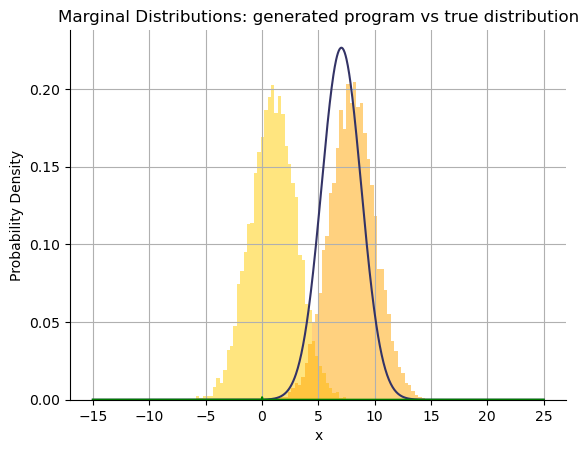

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import uniform

# Define the range for the uniform distribution
x = np.linspace(-15, 25, 1000)
x = torch.tensor(x)
y_0 = [output_dist.gm.marg_pdf(xi,0) for xi in x]
y_1 = [output_dist.gm.marg_pdf(xi,1) for xi in x]

fig, ax = plt.subplots()


ax.plot(x,y_0, label='Program "var 0"', color = '#333366')
ax.plot(x,y_1, label='Program "var 1"', color = 'green')

ax.hist([pair[0] for pair in data], bins=50, density=True, alpha=0.5, color = '#FFCC00')
ax.hist([pair[1] for pair in data], bins=50, density=True, alpha=0.5, color = 'orange')
ax.set_title("Marginal Distributions: generated program vs true distribution")
#ax.set_title("Uniform Distribution (approximation with many components)")
ax.set_xlabel("x")
ax.set_ylabel("Probability Density")

# Remove the upper and right borders
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Add grid, legend and show the plot
ax.grid(True)
#ax.legend()
plt.show()



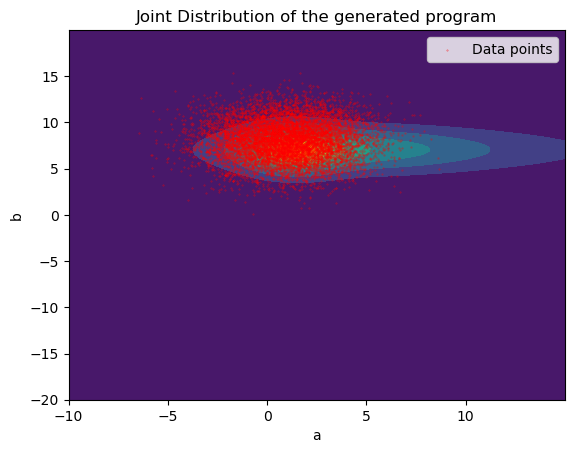

In [ ]:
#3D image of the joint distribution
from mpl_toolkits.mplot3d import Axes3D

def get_mixture_pdf1(x, y):
    pdf = 0
    indexes = {element: [index for index, value in enumerate(output_dist.var_list) if value == element] for element in data_var_list}
    for i in range(output_dist.gm.n_comp()):
        marginal_means = []
        covariance_index = []
        for element, index_list in indexes.items():
            marginal_means.append(output_dist.gm.mu[i][index_list][0])
            covariance_index.append(index_list[0])

        marginal_covariance_matrix = output_dist.gm.sigma[i][np.ix_(covariance_index,covariance_index)]
        
        pdf+= + output_dist.gm.pi[i] * multivariate_normal.pdf([x, y], mean = marginal_means, cov = marginal_covariance_matrix, allow_singular=True)

    return pdf

def get_mixture_pdf(point):
    pdf = 0
    indexes = {element: [index for index, value in enumerate(output_dist.var_list) if value == element] for element in data_var_list}
    for i in range(output_dist.gm.n_comp()):
        marginal_means = []
        covariance_index = []
        for element, index_list in indexes.items():
            marginal_means.append(output_dist.gm.mu[i][index_list][0])
            covariance_index.append(index_list[0])

        marginal_covariance_matrix = output_dist.gm.sigma[i][np.ix_(covariance_index,covariance_index)]
        
        pdf+= + output_dist.gm.pi[i] * multivariate_normal.pdf(point, mean = marginal_means, cov = marginal_covariance_matrix, allow_singular=True)

    return pdf
        


x, y = np.mgrid[-10:15:.01, -20:20:.01]
pos = np.dstack((x, y))
#rv = multivariate_normal([0.5, -0.2], [[2.0, 0.3], [0.3, 0.5]])
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.contourf(x, y, get_mixture_pdf(pos))
ax2.scatter([pair[0] for pair in data], [pair[1] for pair in data], color = 'red', alpha = 0.7, s = 0.1, label = 'Data points')
ax2.set_title("Joint Distribution of the generated program")
ax2.set_xlabel("a")
ax2.set_ylabel("b")
ax2.legend()